In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emoji
# !pip install datasets

In [ ]:
# Data Handling
import os
import re
import string
import numpy as np
import pandas as pd
from numpy import array
from numpy import asarray
from numpy import zeros

# NLP Preprocessing
# import nltk
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Machine Learning & Model Evaluation
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    confusion_matrix, accuracy_score
)
# from skmultilearn.adapt import MLkNN

# Deep Learning (Keras & TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Activation, Concatenate
)
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import emoji


In [ ]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_en_l1.csv')
d3= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_en_l3.csv')

d1_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_en_l1.csv')
d3_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_en_l3.csv')


In [ ]:
def normalize_text(text):
  # emoji_pattern = re.compile("["
  #                             u"\U0001F600-\U0001F64F"  # emoticons
  #                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  #                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
  #                             u"\U0001F700-\U0001F77F"  # alchemical symbols
  #                             u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
  #                             u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
  #                             u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
  #                             u"\U0001FA00-\U0001FA6F"  # Chess Symbols
  #                             u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
  #                             u"\U00002702-\U000027B0"  # Dingbats
  #                             u"\U000024C2-\U0001F251"
  #                             "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji.demojize(text)
  text = text.replace("ðŸ¤§", " ")
  text = text.replace("&amp;", " ")
  text = text.replace("\n", " ")
  text = text.replace("ðŸ˜¡", " ")
  # text = emoji_pattern.sub(r'', text)
  return text

d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1_test['text'] = d1_test['text'].apply(lambda x: normalize_text(x))

d3['text'] = d3['text'].apply(lambda x: normalize_text(x))
d3_test['text'] = d3_test['text'].apply(lambda x: normalize_text(x))

In [ ]:
X1 = list(d1['text'])
X1_test = list(d1_test['text'])
X3 = list(d3['text'])
X3_test = list(d3_test['text'])

col_lst = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
for col in col_lst:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')
    d1_test[col] = pd.to_numeric(d1_test[col], errors='coerce')

    d3[col] = pd.to_numeric(d3[col], errors='coerce')
    d3_test[col] = pd.to_numeric(d3_test[col], errors='coerce')


d1['label_1'] = d1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d1_test['label_1'] = d1_test[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d3['label_3'] = d3[col_lst].max(axis=1, skipna=True).astype(int)
d3_test['label_3'] = d3_test[col_lst].max(axis=1, skipna=True).astype(int)


d1 = d1.drop(col_lst, axis=1)
d1_test = d1_test.drop(col_lst, axis=1)
d3 = d3.drop(col_lst, axis=1)
d3_test = d3_test.drop(col_lst, axis=1)

d1['label_1'] = d1['label_1'].astype(int)
d1_test['label_1'] = d1_test['label_1'].astype(int)
d3['label_3'] = d3['label_3'].astype(int)
d3_test['label_3'] = d3_test['label_3'].astype(int)


d1 = d1[['label_1', 'text']]
d1_test = d1_test[['label_1', 'text']]
d1_test

d3 = d3[['label_3', 'text']]
d3_test = d3_test[['label_3', 'text']]
d3_test

,label_3,text
0,1,who s this tweet about bitch it s about you ...
1,0,alkalamba should’ve used her slippers to slap...
2,1,coronavillains covididiot is a do...
3,1,acts like the female governors of stat...
4,1,let us celebrate “secular” as a beautiful w...
...,...,...
1102,1,you should be tired of not having any kind of ...
1103,0,“the limits of tyrants are prescribed by the e...
1104,1,:Cancer::crab: like wtf my symbol is and i’m...
1105,1,:United_States: marry a millionaire guy divo...


In [ ]:
dn = pd.concat([d1, d3.drop(columns=['text'])], axis=1)
dn_test = pd.concat([d1_test, d3_test.drop(columns=['text'])], axis=1)

dn = dn[['text', 'label_1', 'label_3']]
dn_test = dn_test[['text', 'label_1', 'label_3']]
dn_test

,text,label_1,label_3
0,who s this tweet about bitch it s about you ...,1,1
1,alkalamba should’ve used her slippers to slap...,0,0
2,coronavillains covididiot is a do...,1,1
3,acts like the female governors of stat...,1,1
4,let us celebrate “secular” as a beautiful w...,1,1
...,...,...,...
1102,you should be tired of not having any kind of ...,1,1
1103,“the limits of tyrants are prescribed by the e...,0,0
1104,:Cancer::crab: like wtf my symbol is and i’m...,1,1
1105,:United_States: marry a millionaire guy divo...,1,1


In [ ]:
# Create new label column based on logic
def assign_label(row):
    label_1 = row['label_1']
    label_3 = row['label_3']

    # Handle NaN cases (rows with only label_1 or label_3)
    if pd.isna(label_1) and pd.isna(label_3):
        return np.nan  # Both missing
    elif pd.isna(label_1):
        # Only label_3 exists (from d3, d3_test)
        return 1 if label_3 == 1 else 0  # Treat as binary
    elif pd.isna(label_3):
        # Only label_1 exists (from d1, d1_test)
        return 2 if label_1 == 1 else 0  # Treat as binary
    else:
        # Both labels exist (unlikely unless datasets overlap)
        if label_1 == 0 and label_3 == 0:
            return 0
        elif label_1 == 0 and label_3 == 1:
            return 1
        elif label_1 == 1 and label_3 == 0:
            return 2
        else:  # label_1 == 1 and label_3 == 1
            return 3

# dn_new=dn.copy()
dn['label'] = dn.apply(assign_label, axis=1)

# dn_test_new=dn_test.copy()
dn_test['label'] = dn_test.apply(assign_label, axis=1)

dn

,text,label_1,label_3,label
0,this is our history for shia and sunni ...,0,0,0
1,if this is grilling then wht wud u call t...,1,1,3
2,look at madam locals attacked no religion...,0,0,0
3,our beloved yogi ji has given money home and...,1,1,3
4,i gonna kill that bitch bitvj imma kill you...,1,1,3
...,...,...,...,...
6526,“mama let’s research” bitch suck my dick :loud...,0,0,0
6527,:face_with_tears_of_joy::face_with_tears_of_jo...,0,0,0
6528,:face_with_tears_of_joy::face_with_tears_of_jo...,0,0,0
6529,:smiling_face_with_sunglasses: boys only luxur...,1,1,3


In [ ]:
dn = dn[['label', 'text']].copy()
dn_test = dn_test[['label', 'text']].copy()
dn

print(dn['label'].value_counts())
print(dn_test['label'].value_counts())

label
0    4034
3    1248
1    1125
2     124
Name: count, dtype: int64
label
3    450
0    395
1    238
2     24
Name: count, dtype: int64


In [ ]:
y_data1 = dn["label"]
# y_data2 = d2["label"]
# y_data3 = d3["label"]
# # print(y_data)
y1 = y_data1.values
# y2 = y_data2.values
# y3 = y_data3.values
print(y1)
print(len(y1))
# print(y2)
# print(len(y2))
# print(y3)
# print(len(y3))

[0 3 0 ... 0 3 0]
6531


In [ ]:
# y1.#
unique_values, counts = np.unique(y1, return_counts=True)
print(unique_values)
print(counts)
print(counts[0]/counts[1])


[0 1 2 3]
[4034 1125  124 1248]
3.585777777777778


In [ ]:
d1 = dn.copy()

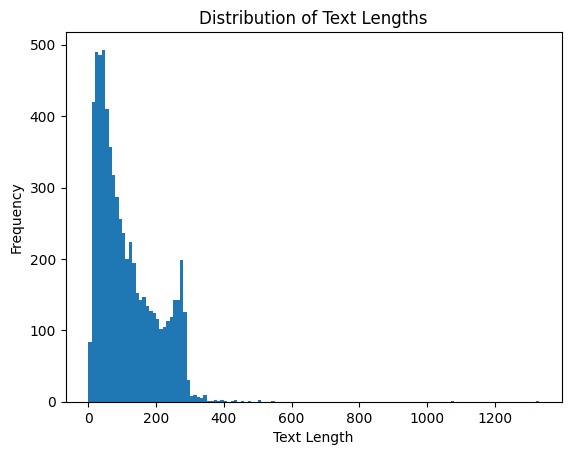

Average Text Length: 112.52273771244832
Length 0-10: 84 84
Length 10-20: 420 504
Length 20-30: 490 994
Length 30-40: 485 1479
Length 40-50: 493 1972
Length 50-60: 410 2382
Length 60-70: 357 2739
Length 70-80: 317 3056
Length 80-90: 287 3343
Length 90-100: 256 3599
Length 100-110: 236 3835
Length 110-120: 200 4035
Length 120-130: 224 4259
Length 130-140: 194 4453
Length 140-150: 152 4605
Length 150-160: 143 4748
Length 160-170: 147 4895
Length 170-180: 134 5029
Length 180-190: 127 5156
Length 190-200: 124 5280
Length 200-210: 116 5396
Length 210-220: 102 5498
Length 220-230: 104 5602
Length 230-240: 113 5715
Length 240-250: 118 5833
Length 250-260: 143 5976
Length 260-270: 143 6119
Length 270-280: 198 6317
Length 280-290: 126 6443
Length 290-300: 31 6474
Length 300-310: 8 6482
Length 310-320: 9 6491
Length 320-330: 7 6498
Length 330-340: 5 6503
Length 340-350: 9 6512
Length 350-360: 1 6513
Length 360-370: 1 6514
Length 370-380: 3 6517
Length 380-390: 1 6518
Length 390-400: 2 6520
Length

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate the lengths of each text element
text_lengths = d1['text'].str.len()

# Create a histogram with bins of size 10
plt.hist(text_lengths, bins=range(0, text_lengths.max() + 10, 10))

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

# Calculate and print the average text length
average_length = text_lengths.mean()
print(f"Average Text Length: {average_length}")

# Get counts for each bucket of 10
bins = range(0, text_lengths.max() + 10, 10)
counts, _ = np.histogram(text_lengths, bins=bins)

sum=0
# Print the counts for each bucket
# for i in range(len(bins) - 1):
#     sum+=counts[i]
#     print(f"Length {bins[i]}-{bins[i+1]}: {counts[i]} {sum}")

In [ ]:
import numpy as np

# Total number of samples
total_samples = np.array([4034, 1125, 124, 1248]).sum()

# Class frequencies
class_freq = np.array([4034, 1125, 124, 1248])

# Calculate the class weights
class_weights = total_samples / (len(class_freq) * class_freq)
class_weights

array([ 0.40474715,  1.45133333, 13.16733871,  1.30829327])

In [ ]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
import numpy as np

class MacroF1Callback(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        val_inputs, val_labels = self.validation_data
        predictions = self.model.predict(val_inputs)
        y_true = np.argmax(val_labels, axis=1)
        y_pred = np.argmax(predictions, axis=1)
        macro_f1 = f1_score(y_true, y_pred, average='macro')
        print(f'\nEpoch {epoch+1} — Macro F1-score: {macro_f1:.4f}')


In [ ]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU, MultiHeadAttention
from tensorflow.keras.models import Model
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Bidirectional, GRU, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# ======================
# CONFIGURATION
# ======================
MAX_LEN = 100 # Reduced for English text
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 5e-4
VAL_SPLIT = 0.2
# CLASS_WEIGHT = {0: 1, 1: 3.5, 2: 1, 3: 1}  # Adjusted for English class distribution
CLASS_WEIGHT = {0: 0.404, 1: 1.451, 2: 13.167, 3: 1.308}  # Adjusted for English class distribution
XLM_MODEL_NAME = 'xlm-roberta-base'

# ======================
# MODEL ARCHITECTURE
# ======================

class XLMRobertaEmbedding(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.xlm_model = TFXLMRobertaModel.from_pretrained(model_name)

        for i in range(6):  # You can change how many layers you want frozen
            self.xlm_model.roberta.encoder.layer[i].trainable = False

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.xlm_model(
            input_ids,
            attention_mask=attention_mask,
            return_dict=True
        ).last_hidden_state

# def create_model():
#     input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
#     attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

#     # XLM-R Embeddings
#     embeddings = XLMRobertaEmbedding(XLM_MODEL_NAME)([input_ids, attention_mask])

#     # BiGRU with reduced units for English
#     gru_out = Bidirectional(GRU(512, return_sequences=True))(embeddings)

#     # Multi-Head Attention
#     attention = MultiHeadAttention(num_heads=4, key_dim=64)(gru_out, gru_out)

#     # Pooling + Classification
#     pooled = tf.keras.layers.GlobalAveragePooling1D()(attention)
#     dropout = tf.keras.layers.Dropout(0.2)(pooled)
#     output = Dense(4, activation='softmax')(dropout)

#     return Model(inputs=[input_ids, attention_mask], outputs=output)

def create_model():
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

    xlm_model = TFXLMRobertaModel.from_pretrained(XLM_MODEL_NAME)

    # ❄️ Freeze first 6 encoder layers
    for i in range(8):
        xlm_model.roberta.encoder.layer[i].trainable = False

    # ✅ Hugging Face models expect raw Tensors, use Lambda wrapper
    def xlm_embed(inputs):
        input_ids, attention_mask = inputs
        outputs = xlm_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

    embeddings = Lambda(xlm_embed, output_shape=(MAX_LEN, 768))([input_ids, attention_mask])  # (None, 100, 768)

    gru_out = Bidirectional(GRU(512, return_sequences=True))(embeddings)
    attention = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(gru_out, gru_out)
    pooled = GlobalAveragePooling1D()(attention)
    dropout = Dropout(0.3)(pooled)
    output = Dense(4, activation='softmax')(dropout)

    return Model(inputs=[input_ids, attention_mask], outputs=output)


# Load dataset (replace with your English data path)
english_df = d1

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    english_df['text'].values,
    english_df['label'].values,
    test_size=VAL_SPLIT,
    stratify=english_df['label'],
    random_state=42
)

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

# Tokenization
tokenizer = XLMRobertaTokenizer.from_pretrained(XLM_MODEL_NAME)

def preprocess(texts):
    return tokenizer(
        texts.tolist(),
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_enc = preprocess(X_train)
val_enc = preprocess(X_val)

# ======================
# MODEL TRAINING
# ======================
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

for layer in model.layers:
    print(layer.name, layer.trainable)


print("\n\nMODEL SUMMARY\n\n\n")
model.summary()

val_data = (
    {'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask']},
    y_val
)

f1_callback = MacroF1Callback(val_data)
history = model.fit(
    {'input_ids': train_enc['input_ids'], 'attention_mask': train_enc['attention_mask']},
    y_train,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHT,
    callbacks=[f1_callback]
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


input_ids True
attention_mask True
lambda_4 True
bidirectional_6 True
multi_head_attention_5 True
global_average_pooling1d_5 True
dropout_11 True
dense_5 True


MODEL SUMMARY





Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 100, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 100, 1024) │  3,938,304 │ lambda_4[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 1024) │  1,050,368 │ bidirectional_6[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1024)      │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │      4,100 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,992,772 (19.05 MB)

 Trainable params: 4,992,772 (19.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 298ms/step

Epoch 1 — Macro F1-score: 0.2340
164/164 ━━━━━━━━━━━━━━━━━━━━ 89s 464ms/step - accuracy: 0.2434 - loss: 1.5786 - val_accuracy: 0.4399 - val_loss: 1.3338
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step

Epoch 2 — Macro F1-score: 0.3538
164/164 ━━━━━━━━━━━━━━━━━━━━ 67s 371ms/step - accuracy: 0.3953 - loss: 1.3454 - val_accuracy: 0.4262 - val_loss: 1.2502
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step

Epoch 3 — Macro F1-score: 0.2927
164/164 ━━━━━━━━━━━━━━━━━━━━ 60s 369ms/step - accuracy: 0.5054 - loss: 1.1896 - val_accuracy: 0.4422 - val_loss: 1.1871
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step

Epoch 4 — Macro F1-score: 0.3454
164/164 ━━━━━━━━━━━━━━━━━━━━ 84s 382ms/step - accuracy: 0.5198 - loss: 1.1021 - val_accuracy: 0.4514 - val_loss: 1.1946
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step

Epoch 5 — Macro F1-score: 0.3771
164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 378ms/step - accuracy: 0.5284 - loss: 1.0131 - val_accuracy: 

In [ ]:

# # ======================
# # EVALUATION & VISUALIZATION
# # ======================
# def evaluate_model(model, data, true_labels):
#     y_pred = model.predict(data)
#     y_pred_labels = (y_pred > 0.5).astype(int)

#     print("\nClassification Report:")
#     print(classification_report(true_labels, y_pred_labels))
#     print(f"F1 Score: {f1_score(true_labels, y_pred_labels, average='macro'):.4f}")

# print("English Validation Results:")
# evaluate_model(model,
#     {'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask']},
#     y_val
# )

from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data, true_labels, class_names=None):
    # Predict probabilities
    y_pred = model.predict(data)

    # Convert to class labels
    y_pred_labels = y_pred.argmax(axis=1)  # Assuming softmax output
    true_labels = true_labels.argmax(axis=1) if true_labels.ndim > 1 else true_labels

    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, y_pred_labels, target_names=class_names))
    print(f"Macro F1 Score: {f1_score(true_labels, y_pred_labels, average='macro'):.4f}")

    # Confusion matrix
    cm = confusion_matrix(true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
class_names = ['Neutral', 'Gender Abuse', 'Explicit Lang', 'Both']

print("English Validation Results:")
evaluate_model(
    model,
    {'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask']},
    y_val,
    class_names=class_names
)


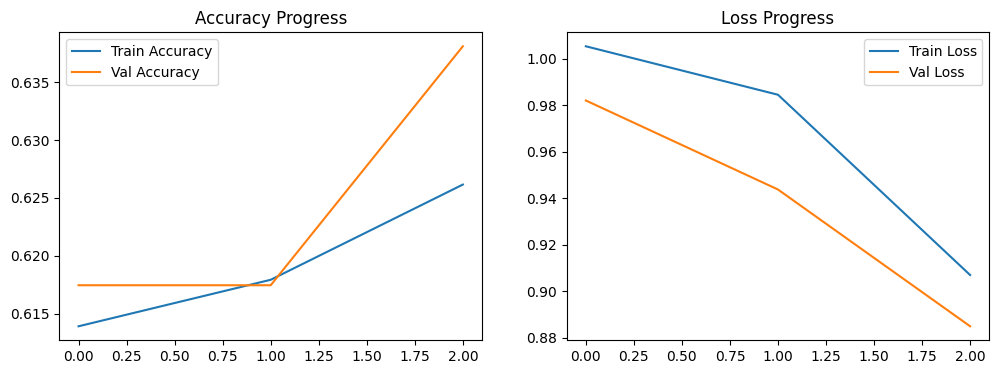

In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Progress')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Progress')
plt.legend()
plt.show()

In [ ]:
def evaluate_on_test(model, dn_test, tokenizer, max_length=100, class_names=None):
    import numpy as np
    from sklearn.metrics import classification_report, f1_score, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    from tensorflow.keras.utils import to_categorical

    # Tokenize test data
    test_enc = tokenizer(
        list(dn_test['text']),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )

    # Convert labels to integers if needed
    test_labels = dn_test['label'].values
    y_true = test_labels

    # Predict
    y_pred_probs = model.predict({'input_ids': test_enc['input_ids'], 'attention_mask': test_enc['attention_mask']})
    y_pred = y_pred_probs.argmax(axis=1)

    # Metrics
    print("\nTest Set Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Test Set')
    plt.show()


In [ ]:
class_names = ['Neutral', 'Gender Abuse', 'Explicit Lang', 'Both']

evaluate_on_test(model, dn_test, tokenizer, class_names=class_names)
